In [159]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

from models import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PCA
## Load data

In [160]:
X = pd.read_csv('./leaf.csv', header=None).values[:,2:]
X.shape

(340, 14)

## 1.1

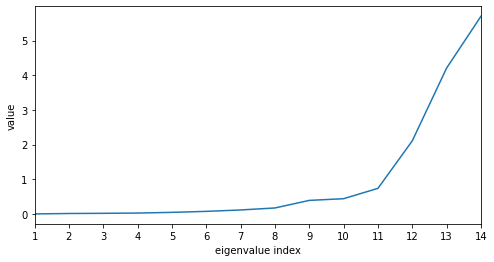

In [161]:
# scale data
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_scaled = (X-mean) / std

# calculate covariance matrix
cov = np.cov(X_scaled.T)

# calculate eigenvectors and eigenvalues
eig_vals, eig_vecs = np.linalg.eig(cov)

# plot eigenvalues in ascending order
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(eig_vals))+1,np.sort(eig_vals))
plt.xlim([1,len(eig_vals)])
plt.xlabel('eigenvalue index')
plt.ylabel('value')
plt.xticks(np.arange(len(eig_vals))+1)
plt.show()

## 1.2

In [162]:
# selecting how many eigenvalues to use (choosing k)
eig_vals_percentage = np.flip(np.sort(eig_vals))/np.sum(eig_vals)
ks = np.arange(len(eig_vals))+1
k_sums = np.zeros_like(eig_vals)
for k, val in enumerate(eig_vals_percentage):
    k_sums[k] = k_sums[k-1]+val
    if k_sums[k]>0.95 and k_sums[k-1]<0.95:
        print(f'k={k+1} is a good choise of k')
pd.DataFrame({'k':ks, 'coverage %':k_sums}, columns= ['k', 'coverage %']).style.hide_index()

k=6 is a good choise of k


k,coverage %
1,0.405919
2,0.705545
3,0.855692
4,0.908231
5,0.939495
6,0.967268
7,0.979499
8,0.987630
9,0.992872
10,0.996110


## 1.3

In [163]:
# printing the eigenvectors for k=2
pd.DataFrame({'w1':eig_vecs[0], 'w2':eig_vecs[1]}, columns= ['w1', 'w2'])

,w1,w2
0,-0.093812,-0.190165
1,-0.192439,-0.025256
2,0.538282,0.519236
3,0.129275,-0.168502
4,-0.172358,0.463153
5,-0.617888,0.470015
6,0.009354,0.177409
7,0.003232,0.371746
8,0.225518,0.179096
9,0.413895,0.128162


## 1.4

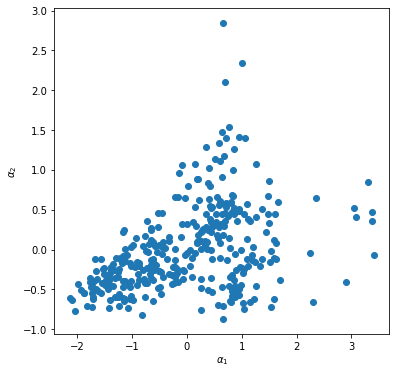

In [164]:
# calculate  and plat data on PCA space
alpha1 = X_scaled.dot(eig_vecs[0])
alpha2 = X_scaled.dot(eig_vecs[1])
plt.figure(figsize=(6,6))
plt.scatter(alpha1,alpha2)
plt.xlabel(r'$\alpha_1$')
plt.ylabel(r'$\alpha_2$')
plt.show()

## 1.5

In [165]:
# calculate mean squared reconstruction error
X_pca = np.zeros_like(X)
for i in range(X_pca.shape[0]):
    X_pca[i] = eig_vecs[:2].T.dot(eig_vecs[:2].dot(X_scaled[i]))
MSE = np.mean((X_scaled-X_pca)**2)
print(f'The Mean squared reconstruction error is {MSE}')

The Mean squared reconstruction error is 0.8945838270456161


# Task 1 - EM Algorithm
## Load Data

In [166]:
data = pd.read_csv('./data.csv', header=None).values
T = data[:,:-1]
y = data[:,-1]
print(T.shape, y.shape)
c_vals = np.array(list(set(y)))
n_d = len(y)
n_c = len(c_vals)
n_w = T.shape[1]

(400, 100) (400,)


In [167]:
# initialize pi #
# pi = np.array([np.sum(y==c)/len(y) for c in c_vals]) # real probabilities
pi = np.ones(n_c) / n_c # works well, but also might be because it's also the real distribution

# initialize mu #
# mu = np.array([[np.sum(T[:,j]*(y==c_vals[c]))/np.sum(T) for c in range(n_c)] for j in range(n_w)]) # real probabilities
mu = np.random.uniform(size=(n_w,n_c)) # works well, but obviously results depends on iterations and how lucky we are with the random values
# mu = np.ones((n_w,n_c)) # doesn't work, causes all dataset to concentrate into a single label
mu /= np.sum(mu) # normalization of mu

# initialize gamma #
gamma = np.zeros((n_d,n_c))

# iterate EM algorithm
iters = 50
for iter in range(iters):
    # E-step
    for i in range(n_d):
        for c in range(n_c):
            gamma[i,c] = np.nan_to_num((pi[c]*np.prod(mu[:,c]**T[i,:])) / (np.sum(pi*np.prod(mu**np.tile(T[i,:],(n_c,1)).T,axis=0))))
    # M-step
    for c in range(n_c):
        pi[c] =  np.sum(gamma[:,c]) / n_d
        for j in range(n_w):
            mu[j,c] = np.sum(gamma[:,c]*T[:,j]) / np.sum(np.tile(gamma[:,c],(100,1)).T*T)


In [168]:
# check accuracy
y_pred = np.argmax(gamma,axis=1)
y_pred_matched = np.zeros_like(y_pred)
for val in list(set(y_pred)):
    hist, bins = np.histogram(y[y_pred==val],bins=np.arange(c_vals.min(),c_vals.max()+2))
    print(f'predicted label {val} is most likely label {c_vals[np.argmax(hist)]} {hist}')
    y_pred_matched[y_pred==val] = c_vals[np.argmax(hist)]
acc = np.mean(y==y_pred_matched)
print(f'The accuracy of the EM Algorithm is {acc}')

predicted label 0 is most likely label 2 [ 0 29  0 12]
predicted label 1 is most likely label 2 [27 32  0  0]
predicted label 2 is most likely label 3 [ 73  18 100   0]
predicted label 3 is most likely label 4 [ 0 21  0 88]
The accuracy of the EM Algorithm is 0.6225


# Task 2 - MCMC Algorithm

## Load data and declare distribution parameters

In [169]:
x = np.loadtxt('./data2.txt')
K = 2

Initial conditions and parameters:
nk  = [493 507]
rho = [0.52496 0.47504]
phi = [37.36815 37.36815]
mu  = [0.33228 0.52865]



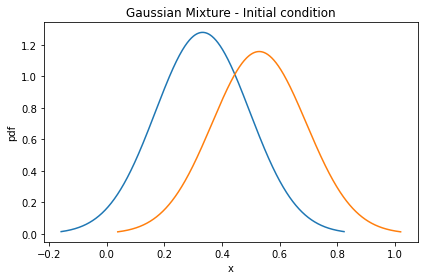

In [170]:
%reload_ext autoreload
np.set_printoptions(precision=5)
NUMBER = 3

n_iter = 1000

while(True):

    # Distribution parameters 
    delta = np.ones(K)                                  # Dirichlet distribution parameters: delta
    a = 9*np.random.rand() + 1e-9                       # Gamma distribution parameters: shape
    b = 2*np.random.rand() + 1e-9                       # Gamma distribution parameters: scale
    m = x.std()*np.random.randn(K) + np.repeat(x.mean(),K)      # Normal distribuion parameters: mean 
    alpha = np.random.rand(K) + 1e-9    

    # 1. Set initials values rho, mu, phi
    rho = np.random.dirichlet(delta)                                # rho, size=K
    phi = np.repeat(1/np.var(x), K)                                 # phi, size=K 
    mu = 1/np.sqrt(phi)*np.random.randn(K) + m     # mu,  size=K

    z = np.argmax(p_zi_xi(x,rho,mu,phi),axis=1)
    nk = np.sum(z.reshape(-1,1) == np.arange(K), axis=0)    # calculate nk for each k
    if all( nk > x.shape[-1]/(2*K)):
         break

print('Initial conditions and parameters:')
print('nk  = {}'.format(nk))
print('rho = {}'.format(rho))
print('phi = {}'.format(phi))
print('mu  = {}\n'.format(mu))

# Print initials parameters and plot the gaussians
for k in range(K):
    mu_p = mu[k]
    variance = 1/phi[k]
    sigma = math.sqrt(variance)
    x_p = np.linspace(mu_p - 3*sigma, mu_p + 3*sigma, 1000)
    plt.plot(x_p, rho[k]*stats.norm.pdf(x_p, mu_p, sigma),label=r'$k={}$'.format(k+1))

plt.title('Gaussian Mixture - Initial condition')
plt.xlabel('x')
plt.ylabel('pdf')
plt.tight_layout()
plt.savefig('gaussian_ini_0{}.eps'.format(NUMBER))
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
---------------------------------------- 
Computed parameters:
rho = [0.57631 0.42369]
phi = [ 85.42743 107.74317]
mu  = [0.34565 0.61152]



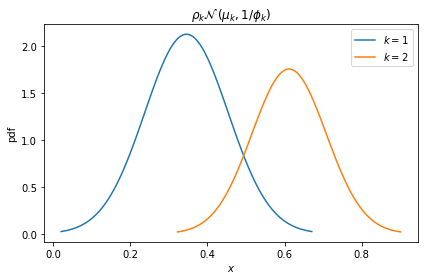

In [171]:
# Run the MCMC algorithm

for i in range(n_iter):
    # 2. Update z sampling z^(j+1)
    z = np.argmax(p_zi_xi(x,rho,mu,phi),axis=1)             
    nk = np.sum(z.reshape(-1,1) == np.arange(K), axis=0)    # calculate nk for each k

    # 3. Update rho sampling from rho^(j+1)
    delta_conj = delta + nk                     # Delta conjugate
    rho = np.random.dirichlet(delta_conj)       

    # 4. Update phi sampling from phi^(j+1)
    a_conj = a + nk
    one_hot = np.identity(K)[z].astype(bool)    # One hot encoding to calculate b_conj
    b_conj = b + np.array([np.power(x[one_hot[:,k]]-mu[k], 2).sum() for k in range(K)])
    phi = np.random.gamma(a_conj/2,2/b_conj,size=(K)) 

    # 5. Update mu sampling from mu^(j+1)
    alpha_conj = alpha + nk
    x_mean = np.array([x[one_hot[:,k]].mean() for k in range(K)])
    x_mean[np.isnan(x_mean)] = 0                                   
    m_conj = (alpha*m + nk*x_mean)/(alpha + nk)                      # Validation of mean of an empty dataset
    mu = np.sqrt(1/(alpha_conj*phi)) * np.random.randn(K) + m_conj

# Print computed parameters and plot the gaussians
print(40*'-','\nComputed parameters:')
print('rho = {}'.format(rho))
print('phi = {}'.format(phi))
print('mu  = {}\n'.format(mu))

for k in range(K):
    mu_p = mu[k]
    variance = 1/phi[k]
    sigma = math.sqrt(variance)
    x_p = np.linspace(mu_p - 3*sigma, mu_p + 3*sigma, 100)
    plt.plot(x_p, rho[k]*stats.norm.pdf(x_p, mu_p, sigma),label=r'$k={}$'.format(k+1))

plt.title(r'$\rho_k \mathcal{N}\, \left( \mu_k, 1/\phi_k \right)$')
plt.xlabel(r'$x$')
plt.ylabel('pdf')
plt.legend()
plt.tight_layout()
plt.savefig('gaussian_mix_0{}.eps'.format(NUMBER))
plt.show()

### Plot parameters pdf's

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


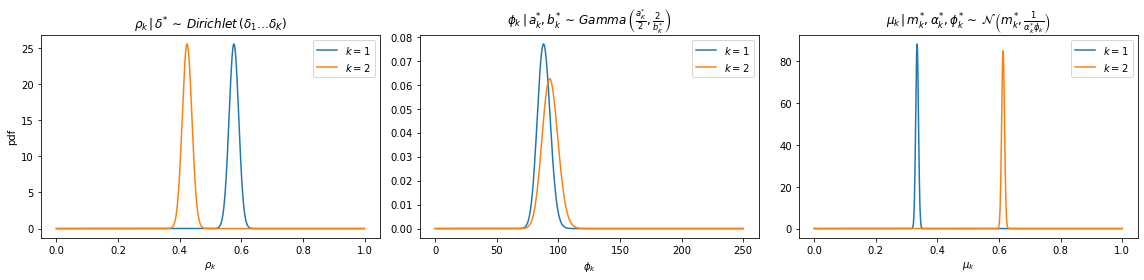

In [172]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

# Plot rho distribution
x_p = np.arange(0,1,0.001)
z_p = np.zeros(x_p.shape)
for i in range(len(x_p)):
    z_p[i] = stats.dirichlet.pdf(np.array([x_p[i],1-x_p[i]]),delta_conj)
ax[0].plot(x_p,z_p,label=r'$k=1$')
for i in range(len(x_p)):
    z_p[i] = stats.dirichlet.pdf(np.array([1-x_p[i],x_p[i]]),delta_conj)
ax[0].plot(x_p,z_p,label=r'$k=2$')
ax[0].set_title(r'$\rho_k \,| \, \delta^{*} \,\sim\, Dirichlet \,\left( \delta_1 \dots \delta_K \right)$')
ax[0].set_xlabel(r'$\rho_k$')
ax[0].set_ylabel('pdf')

# Plot phi and mu distribution
for k in range(K):
    x_p = np.linspace(0,250, 1000)
    ax[1].plot(x_p, stats.gamma.pdf(x_p, a_conj[k]/2, scale=2/b_conj[k]), label=r'$k={}$'.format(k+1))
    
    x_p = np.linspace(0,1, 1000)
    ax[2].plot(x_p, stats.norm.pdf(x_p, m_conj[k], np.sqrt(1/(alpha_conj[k]*phi[k]))),label=r'$k={}$'.format(k+1))

ax[1].set_title(r'$\phi_k \, | \,a_k^{*}, b_k^{*} \,\sim\, Gamma\,\left(\frac{a_K^{*}}{2},\frac{2}{b_K^{*}}\right)$')
ax[1].set_xlabel(r'$\phi_k$')

ax[2].set_title(r'$\mu_k \, | \,m_k^{*}, \alpha_k^{*}, \phi_k^{*} \,\sim\, \mathcal{N}\,\left(m_k^{*},\frac{1}{\alpha_k^{*}\phi_k}\right)$')
ax[2].set_xlabel(r'$\mu_k$')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.savefig('parameters_0{}.eps'.format(NUMBER))
plt.show()


### Plot Gaussian Mixture Model

---------------------------------------- 
Posterior mean of unknown parameters:
rho_mean = [0.57514 0.42486]
phi_mean = [88.09526 93.38573]
mu_mean  = [0.33383 0.61301]



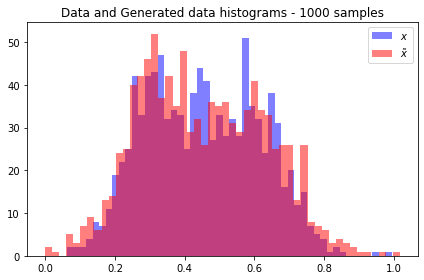

In [173]:
N = 1000
rho_mean = np.random.dirichlet(delta_conj, size=N).mean(axis=0)
phi_mean = np.random.gamma(a_conj/2,scale=2/b_conj,size=(N,K)).mean(axis=0)
mu_mean  = (m_conj + np.sqrt(1/(alpha_conj*phi_mean))*np.random.randn(N,K)).mean(axis=0)

print(40*'-','\nPosterior mean of unknown parameters:')
print('rho_mean = {}'.format(rho_mean))
print('phi_mean = {}'.format(phi_mean))
print('mu_mean  = {}\n'.format(mu_mean))

x_tilde = np.zeros(1000)
n_rho = np.round(rho_mean*N).astype('int')
x_tilde[:n_rho[0]] = mu_mean[0] + np.sqrt(1/phi_mean[0])*np.random.randn(n_rho[0].astype('int'))
x_tilde[n_rho[0]:] = mu_mean[1] + np.sqrt(1/phi_mean[1])*np.random.randn(1000-n_rho[0].astype('int'))

fig, ax = plt.subplots(1)
ax.hist(x,bins=50, edgecolor='None', alpha = 0.5, color= 'b', label=r'$x$'); 
ax.hist(x_tilde,bins=50, edgecolor='None', alpha = 0.5, color= 'r', label=r'$\tilde{x}$'); 
ax.legend();
ax.set_title('Data and Generated data histograms - 1000 samples');
plt.tight_layout();
ax.set_rasterized(True)
plt.savefig('histograms_0{}.eps'.format(NUMBER),dpi=300);
plt.show();
